# Mask Segmentation

In [ ]:
# %pip install numpy
# %pip install opencv-python
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn
# %pip install scikit-image
# %pip install scipy


In [20]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.color import label2rgb
from sklearn.metrics import jaccard_score


## c. Region Segmentation Using Traditional Techniques (3 Marks)

i. Implement a region-based segmentation method (e.g., thresholding, edge
    detection) to segment the mask regions for faces identified as "with mask."

ii. Visualize and evaluate the segmentation results.

#### Load Data

In [21]:


# Set random seed
np.random.seed(42)

# Folder Paths 
image_dir = "../Data/MSFD/1/face_crop"
ground_truth_dir = "../Data/MSFD/1/face_crop_segmentation"

# Create a DataFrame of file paths
def create_file_df(image_dir,  ground_truth_dir):
    """Create a DataFrame with file paths for images, masks, and ground truths."""
    data = {
        "image_path": [],
        "ground_truth_path": []
    }
    
    # Ensure filenames match across directories
    image_fnames = sorted(os.listdir(image_dir))
    ground_truth_fnames = sorted(os.listdir(ground_truth_dir))
    
    assert len(image_fnames) == len(ground_truth_fnames), "Filename mismatch!"
    
    # Populate DataFrame
    for fname in image_fnames:
        data["image_path"].append(os.path.join(image_dir, fname))
        data["ground_truth_path"].append(os.path.join(ground_truth_dir, fname))
    
    return pd.DataFrame(data)

# Create DataFrame
df = create_file_df(image_dir, ground_truth_dir)
print(f"Total files: {len(df)}")

# Step 2: Split into training and testing sets (.1% each)
train_df, test_df = train_test_split(df, test_size=0.01, train_size=0.01, random_state=42)
print(f"\nTraining set: {len(train_df)} files")
print(f"Testing set: {len(test_df)} files")


Total files: 9383

Training set: 93 files
Testing set: 94 files


In [22]:
train_df.iloc[49]

image_path                       ../Data/MSFD/1/face_crop\004130_1.jpg
ground_truth_path    ../Data/MSFD/1/face_crop_segmentation\004130_1...
Name: 4709, dtype: object

In [23]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df.head()

,image_path,ground_truth_path
0,../Data/MSFD/1/face_crop\000928_1.jpg,../Data/MSFD/1/face_crop_segmentation\000928_1...
1,../Data/MSFD/1/face_crop\006654_1.jpg,../Data/MSFD/1/face_crop_segmentation\006654_1...
2,../Data/MSFD/1/face_crop\007144_2.jpg,../Data/MSFD/1/face_crop_segmentation\007144_2...
3,../Data/MSFD/1/face_crop\003408_4.jpg,../Data/MSFD/1/face_crop_segmentation\003408_4...
4,../Data/MSFD/1/face_crop\000675_1.jpg,../Data/MSFD/1/face_crop_segmentation\000675_1...


In [24]:
image_path_0 = train_df.loc[0, "image_path"]
print(image_path_0)


../Data/MSFD/1/face_crop\000928_1.jpg


In [25]:

def load_image(path,  resize=(256, 256), is_ground_truth = False):
    """Load and preprocess an image or mask."""
    if not is_ground_truth :
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, resize)
    else :
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, resize)
        _,img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        img = img/255
        img = img.astype(np.uint8)

    return img


def load_all_img(df, resize=(256, 256)):
    
    num_samples = len(df)
    height, width = resize

    # Initialize empty numpy arrays
    images = np.empty((num_samples, height, width), dtype=np.uint8)
    ground_truth = np.empty((num_samples, height, width), dtype=np.uint8)

    for i, (_, row) in enumerate(df.iterrows()):
        images[i] = load_image(row["image_path"], resize)
        ground_truth[i] = load_image(row["ground_truth_path"], resize, is_ground_truth=True)

    return images, ground_truth

train_imgs, train_ground_truths  = load_all_img(train_df)
print(train_ground_truths.shape)


(93, 256, 256)


In [26]:


def percentile_thresholds(gray_img, low_percentile=20, high_percentile=80):
    """Get thresholds using percentiles with edge case handling"""
    # Calculate percentiles
    low_val = np.percentile(gray_img, low_percentile)
    high_val = np.percentile(gray_img, high_percentile)
    
    # Handle edge cases (all dark/bright images)
    if high_val - low_val < 5:  # No significant intensity variation
        low_val = max(0, low_val - 10)
        high_val = min(255, high_val + 10)
        
    return low_val, high_val


# Visualization helper
def plot_hist_thresholds(gray_img, low, high):
    plt.figure(figsize=(10,4))
    hist = cv2.calcHist([gray_img], [0], None, [256], [0,256])
    plt.plot(hist, color='k')
    plt.axvline(low, color='r', linestyle='--', label=f'Low: {low}')
    plt.axvline(high, color='b', linestyle='--', label=f'High: {high}')
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

Percentile thresholds: Low=11.0, High=98.0


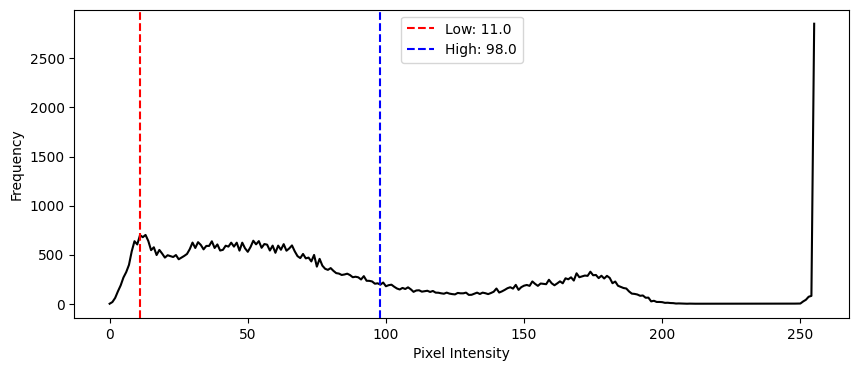

In [27]:
i =14
# Load image
gray_img = train_imgs[i]


canny_low, canny_high = percentile_thresholds(gray_img, low_percentile=5, high_percentile=70)
print(f"Percentile thresholds: Low={canny_low}, High={canny_high}")
plot_hist_thresholds(gray_img, canny_low, canny_high)


#### Canny Edge Detection

In [28]:
def canny_edge(gray_img, canny_low_edge_percentile=5, canny_high_edge_percentile=70, verbose=False): 


    # gaussian blur
    guassian_blur = cv2.GaussianBlur(gray_img, (11,11), 0)

    canny_low, canny_high = percentile_thresholds(gray_img, low_percentile=canny_low_edge_percentile, high_percentile=canny_high_edge_percentile)
    if verbose:
        print(f'Canny_low = {canny_low} Canny_high = {canny_high}')
    #  Apply Canny Edge Detection
    canny = cv2.Canny(guassian_blur, canny_low, canny_high)  

    return canny



In [29]:
def segment_img(gray_img, threshold_img, marker_low_percentile=25, marker_high_percentile=75, mask='light') :
    #efine markers
    markers = np.zeros_like(gray_img, dtype=np.int32)
    marker_low, marker_high = percentile_thresholds(gray_img, low_percentile=marker_low_percentile, high_percentile=marker_high_percentile)
   

     #white mask
    if mask=='light' :
        markers[gray_img < marker_low] = 1
        markers[gray_img > marker_high] = 2
    else :
        #dark mask 
        markers[gray_img < marker_low] = 2
        markers[gray_img > marker_high] = 1

    segmented_coins = watershed(threshold_img,  markers)
    segmented_coins_int8 = segmented_coins.astype(np.uint8)

    return markers, segmented_coins_int8


#### WaterShed Segmentation

In [30]:


def get_segmented_mask(segmented_chunks) :

    segmentation_chunks = ndi.binary_fill_holes(segmented_chunks - 1)

    # Label connected components
    labeled_segments, num_segments = ndi.label(segmentation_chunks)

    # Find the largest cluster
    if num_segments > 0:
        # Compute the size of each cluster
        sizes = ndi.sum(segmentation_chunks, labeled_segments, range(1, num_segments + 1))
        
        # Find the label of the largest cluster
        largest_label = np.argmax(sizes) + 1  # +1 because labels start from 1
        
        # Create a binary mask for the largest cluster
        largest_cluster = (labeled_segments == largest_label).astype(np.uint8) * 255
    else:
        largest_cluster = np.zeros_like(segmented_chunks, dtype=np.uint8)
    
    largest_cluster_binary = (largest_cluster/np.max(largest_cluster)).astype(np.uint8)
    return largest_cluster, largest_cluster_binary





#### Mask color Detection

In [42]:
def detect_mask_polarity_robust(image, num_regions=3):
    """
    Determine if the mask is lighter/darker using concentric regions.
    
    image: Input grayscale image (uint8).
    num_regions: Number of concentric square regions.
    
    Returns:
        -1: Mask is darker (black mask)
         1: Mask is lighter (white mask)
    """
    h, w = image.shape
    center_y, center_x = h // 2, w // 2
    
    polarity_scores = []
    
    # define concentric region sizes
    for i in range(1, num_regions + 1):
        scale = 0.25 * i  # 25%, 50%, 75% for 3 regions
        region_h = int(h * scale)
        region_w = int(w * scale)
        
        # define region bounds
        y_start = center_y - region_h // 2
        y_end = center_y + region_h // 2
        x_start = center_x - region_w // 2
        x_end = center_x + region_w // 2
        
        # ensure regions stay within image bounds
        y_start = max(0, y_start)
        y_end = min(h, y_end)
        x_start = max(0, x_start)
        x_end = min(w, x_end)
        
      
        region = image[y_start:y_end, x_start:x_end]
        if region.size == 0:
            continue
        
        # split into top and bottom halves within the region
        region_h, region_w = region.shape
        top = region[:region_h//2, :]
        bottom = region[region_h//2:, :]
        
        # calculate mean intensities
        top_mean = np.mean(top)
        bottom_mean = np.mean(bottom)
        
        # score polarity for this region (weighted by region area)
        score = (top_mean - bottom_mean) * (region_h * region_w)
        polarity_scores.append(score)
    
    # Determine overall polarity
    total_score = np.sum(polarity_scores)
    return -1 if total_score > 0 else 1  # Positive score = top is brighter → mask is darker


def invert_mask_automatically(gray_img, verbose=False):
    polarity = detect_mask_polarity_robust(gray_img, num_regions=3)
    if verbose :
        if polarity == -1:
            print("Mask is darker (black mask)")
        else:
            print("Mask is lighter (white mask)")
        plt.figure(figsize=(8, 5))
        plt.subplot(1,2,1)
        plt.title("original_img")
        plt.imshow(gray_img, cmap="gray")
        plt.axis("off")
        if(polarity == -1) :
            plt.subplot(1,2,2)
            plt.title("inverted_img")
            plt.imshow((255-gray_img), cmap="gray")
            plt.axis("off")
        plt.show()
    
    return gray_img if polarity == 1 else (255 - gray_img)

#### Calculate IOU Score

In [43]:
def calculate_iou(segmented_image, segment_ground_truth_image) :
    iou = jaccard_score(segmented_image.flatten(), segment_ground_truth_image.flatten(), average='binary')
    return iou

In [44]:
def segment_mask_and_get_iou(gray_img, ground_truth_img, canny_low_edge_percentile=5, canny_high_edge_percentile=70, marker_low_percentile=25, marker_high_percentile=75, verbose=False) :
    
    #automatically detect if mask is light or dark , if dark invert the img
    gray_img_converted = invert_mask_automatically(gray_img=gray_img, verbose=verbose)

    #enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray_img_converted)

    
    canny = canny_edge(gray_img=enhanced, canny_low_edge_percentile =canny_low_edge_percentile , canny_high_edge_percentile=canny_high_edge_percentile, verbose=verbose)
    
    if verbose: 
        plt.figure(figsize=(8, 4))
        plt.suptitle("Canny")
        # Initial Edge Image
        plt.subplot(1, 2, 1)
        plt.imshow(gray_img, cmap="gray")
        plt.title("Inititial Image")
        plt.axis("off")

        # Display the Markers 

        plt.subplot(1, 2, 2)
        plt.imshow(canny, cmap="gray")
        plt.title("Canny Edges")
        plt.axis("off")

        plt.show()

    markers, segmented_chunks = segment_img(gray_img_converted, canny, marker_low_percentile=marker_low_percentile, marker_high_percentile=marker_high_percentile)

    if verbose: 
        plt.figure(figsize=(10, 5))
        plt.suptitle("Watershed Segmentation")
        # Initial Edge Image
        plt.subplot(1, 3, 1)
        plt.imshow(canny, cmap="gray")
        plt.title("Inititial Edge Image")
        plt.axis("off")

        # Display the Markers 

        plt.subplot(1, 3, 2)
        plt.imshow(markers, cmap="nipy_spectral")
        plt.title("Marker Image")
        plt.axis("off")


        plt.subplot(1, 3, 3)
        plt.imshow(segmented_chunks, cmap="gray")
        plt.title("Segmented Image")
        plt.axis("off")

        plt.show()
    
    
    # #get largest cluster
    largest_cluster, largest_cluster_binary = get_segmented_mask(segmented_chunks)

    if verbose :
        # Plot results
        fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
        fig.suptitle("Output")
        axes[0].imshow(gray_img, cmap=plt.cm.gray)
        axes[0].contour(largest_cluster, [0.5], linewidths=1.2, colors='y')
        axes[0].set_title("Largest Cluster Boundary")
        axes[1].imshow(largest_cluster, cmap=plt.cm.gray)
        axes[1].set_title("Largest Cluster")
        axes[2].imshow(ground_truth_img, cmap=plt.cm.gray)
        axes[2].set_title("Ground Truth")
        for a in axes:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
    
    iou_score = calculate_iou(largest_cluster_binary, ground_truth_img )


    return largest_cluster_binary, iou_score


#### Mask Segmentation Sample

Mask is lighter (white mask)


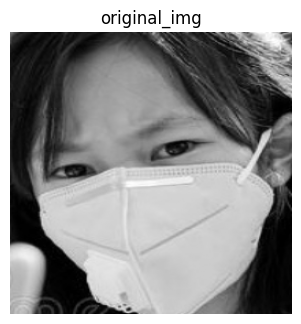

Canny_low = 12.0 Canny_high = 179.0


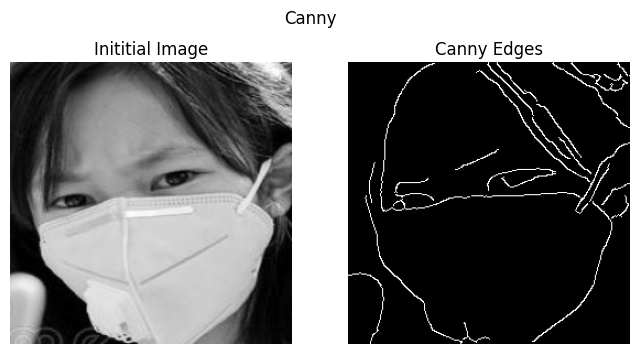

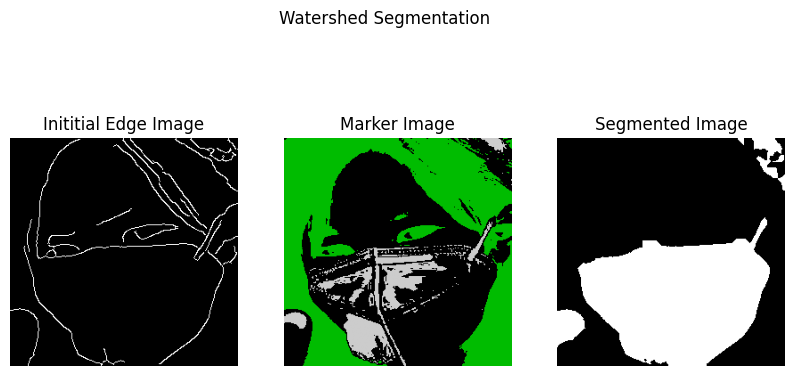

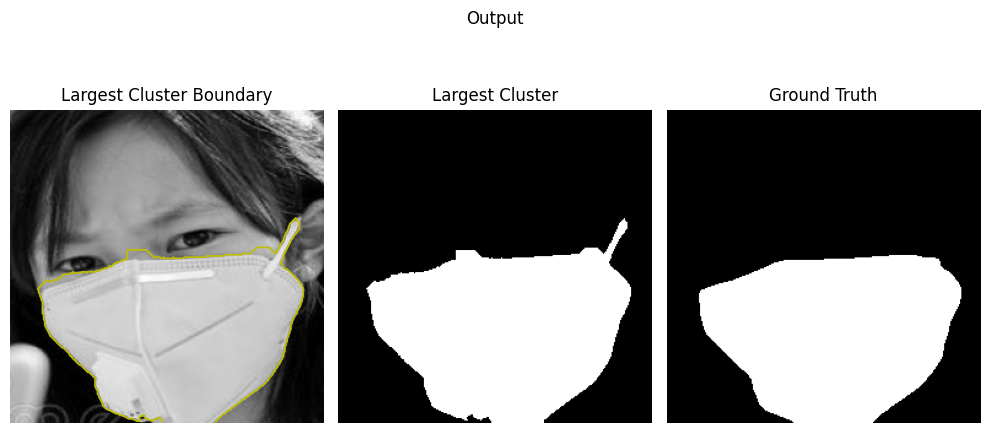

iou score =  0.9520748611657702


In [45]:

i =11

segmented_mask, iou_score = segment_mask_and_get_iou(
            gray_img=train_imgs[i], 
            ground_truth_img=train_ground_truths[i], 
            canny_low_edge_percentile=5, canny_high_edge_percentile=60, #canny gray_img
            marker_low_percentile=40, marker_high_percentile=90,
            verbose=True
        )
print("iou score = ", iou_score)


Mask is darker (black mask)


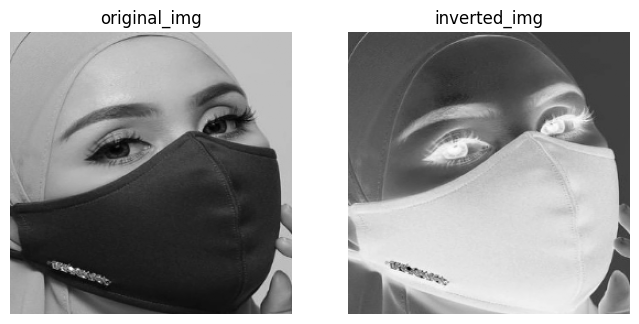

Canny_low = 84.0 Canny_high = 217.0


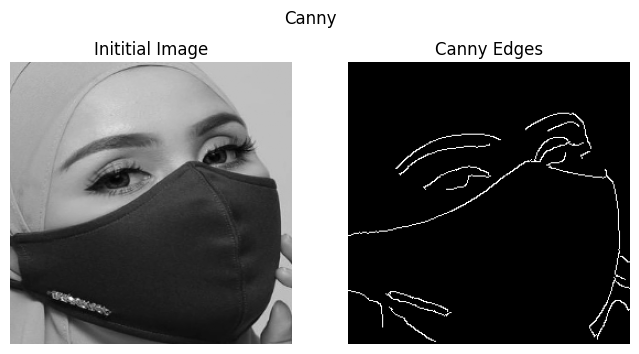

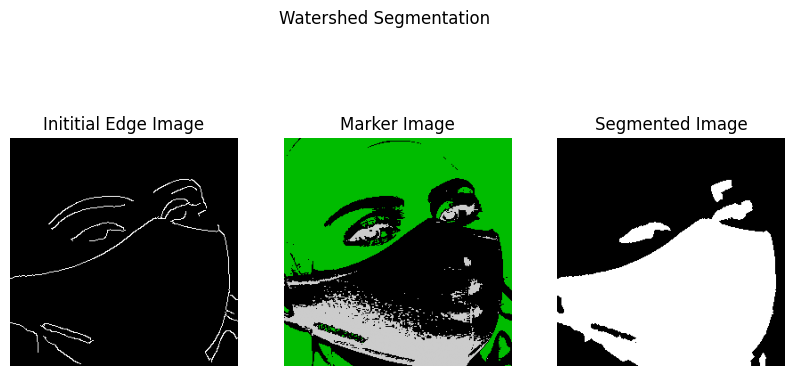

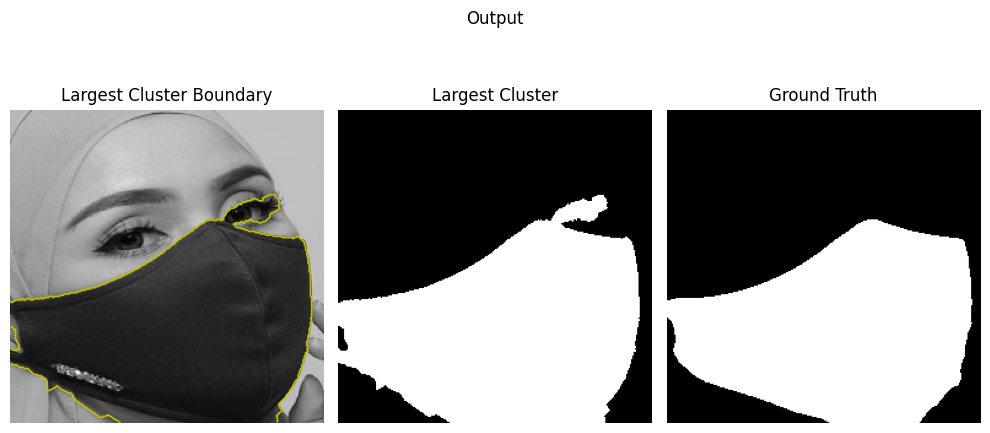

iou score =  0.9259113170956185


In [46]:
i =44

segmented_mask, iou_score = segment_mask_and_get_iou(
            gray_img=train_imgs[i], 
            ground_truth_img=train_ground_truths[i], 
            canny_low_edge_percentile=25, canny_high_edge_percentile=85, #canny gray_img
            marker_low_percentile=45, marker_high_percentile=85,
            verbose=True
        )

print("iou score = ", iou_score)


In [47]:
import time

def test_segmentation(test_df, verbose=False):
    
    # Load all test images and ground truths
    test_imgs, test_ground_truths = load_all_img(test_df)
    print(f"Loaded {len(test_imgs)} test images and {len(test_ground_truths)} ground truths.")
    
    # list to store results
    results = []
    
    for i, (img, ground_truth) in enumerate(zip(test_imgs, test_ground_truths)):
        # Get the filename from the test_df
        filename = test_df.iloc[i]["image_path"] 
        
        # Split the filename by the delimiter ('\') and get the filename
        last_name = filename.split("\\")[-1] 
        

        # Segment the image and calculate IoU
        segmented_mask, iou_score = segment_mask_and_get_iou(
            gray_img=img, 
            ground_truth_img=ground_truth, 
            canny_low_edge_percentile=15, canny_high_edge_percentile=62, #canny gray_img
            marker_low_percentile=50, marker_high_percentile=70,

            verbose=verbose
        )
        
        # Append results to the list
        results.append({"filename": last_name, "iou_score": iou_score})
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'../Output/C/test_iou_scores.csv_{str(int(time.time()))}', index=False)
    # Calculate mean IoU
    mean_iou = results_df["iou_score"].mean()
    median_iou = results_df["iou_score"].median()
    # Display results
    print("\nResults:")
    print(f"\nMean IoU Score: {mean_iou:.4f}")
    print(f"\nMedian IoU Score: {median_iou:.4f}")
    
    return results_df, mean_iou


#### Test the Traditional Segmentation Model

In [48]:

_, _ = test_segmentation(test_df, verbose=False)

Loaded 94 test images and 94 ground truths.

Results:

Mean IoU Score: 0.5366

Median IoU Score: 0.5350
